In [33]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

***
## Coleta de dados

In [34]:
FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.idade': 'idade'}).drop_duplicates().reset_index(drop=True)

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,5532998068556,724235404829984,35415808,2021-02-17,2022-04-09,13,1,1,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),...,PostPaid,NaN,MINAS GERAIS,LINHA ADICIONAL VIVO FAMÃLIA 150GB,0.00,0.0,1.0,0.0,2016.0,31
1,5521988674638,724112005547717,35690411,2021-05-29,NaN,16,1,0,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,...,Controle,NaN,RIO DE JANEIRO,VIVO CTRL DIGITAL_11GB ILIM_,67.14,0.0,1.0,0.0,2020.0,83
2,5555999595054,724065007509989,35175119,2021-03-31,NaN,18,1,0,SAMSUNG,"GALAXY S21 PLUS 5G (SM-G996B,DS)",...,PostPaid,NaN,RIO GRANDE DO SUL,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,0.0,1.0,2020.0,56
3,5527997623734,724113001405241,35991710,2021-05-29,NaN,16,1,0,Multilaser Industrial S.A.,MULTILASER F PRO,...,Controle,NaN,ESPIRITO SANTO,VIVO CONTROLE DIG-7GB_,52.88,0.0,1.0,0.0,2019.0,65
4,5567996046665,724066795495313,35613011,2021-07-23,NaN,14,1,0,SAMSUNG,"GALAXY A01 (SM-A015M,DS)",...,Controle,NaN,MATO GROSSO DO SUL,VIVO CONTROLE 4GB IV,37.49,0.0,1.0,0.0,2020.0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445614,5541992819276,724064006643479,35892323,2021-05-06,NaN,17,1,0,Samsung Korea,GALAXY A52 5G,...,PostPaid,NaN,PARANA,LINHA ADICIONAL VIVO FAMILIA 150GB,0.00,0.0,0.0,1.0,2020.0,63
445615,5511941319852,724102190782505,35092033,2021-03-25,NaN,18,1,0,"Motorola Mobility LLC, a Lenovo Company",GUAM+20,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0.0,1.0,0.0,2020.0,50
445616,5518996551019,724101993846396,35690411,2021-09-03,NaN,13,1,0,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 4GB,37.61,0.0,1.0,0.0,2020.0,58
445617,5561982989551,724066490746154,35614110,2021-10-15,NaN,12,1,0,SAMSUNG,"GALAXY A30 (SM-A305GT,DS)",...,PostPaid,NaN,DISTRITO FEDERAL,TITULAR VIVO FAMILIA 60GB - MENSAL,234.99,0.0,1.0,0.0,2019.0,51


### Limpeza dos dados

In [35]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [36]:
just_check_nan(dados)

Dados com NaN:
dt_fim                     355669
citydesc                   445619
statedesc                      58
subscribermainofferdesc      3580
assignedchargeamount         3513
fl_3g                         100
fl_4g                         100
fl_5g                         100
dt_ano_stts                   100
dtype: int64

columns_with_nan.shape (9,)



In [37]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts'])\
                    .reset_index(drop=True)
# dados_droped

In [38]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      352571
citydesc    441832
dtype: int64

columns_with_nan.shape (2,)



### Equilibrando classes

In [39]:
dados_droped_0 = dados_droped[dados_droped['trocou_aparelho'] == 0].sample(frac=0.53, random_state=3)
dados_droped_1 = dados_droped[dados_droped['trocou_aparelho'] == 1]

In [40]:
dados_droped = pd.concat([dados_droped_0, dados_droped_1]).reset_index(drop=True).sort_values(by='msisdn', ascending=False)
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
150919,5599999844114,724119896659201,35194123,2021-04-30,NaN,17,1,0,APPLE,IPHONE 11 (A2221),...,Controle,NaN,MARANHAO,VIVO CONTROLE 11GB - ANUAL,66.20,0.0,1.0,0.0,2020.0,52
183436,5599999778280,724119113878348,35768964,2021-05-17,2022-05-19,12,1,1,Samsung Korea,GALAXY NOTE20 ULTRA 5G,...,PostPaid,NaN,MARANHAO,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,109.99,0.0,0.0,1.0,2020.0,63
248651,5599999770208,724119112384725,35767712,2021-05-04,2022-05-17,12,1,1,APPLE,IPHONE 12 PRO MAX (A2411),...,PostPaid,NaN,MARANHAO,LINHA ADICIONAL VIVO V,0.00,0.0,0.0,1.0,2020.0,29
68982,5599999530131,724119114015020,35260709,2021-07-09,NaN,15,1,0,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),...,PostPaid,NaN,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017.0,30
134256,5599999523030,724119805984364,35973519,2021-07-14,NaN,15,1,0,APPLE,IPHONE 12 PRO MAX (A2342),...,PostPaid,NaN,MARANHAO,TITULAR VIVO V,1299.99,0.0,0.0,1.0,2021.0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204607,5511910003326,724102090904887,35187408,2021-02-03,2022-05-02,14,1,1,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",...,PostPaid,NaN,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016.0,48
160708,5511910003293,724102007432614,35175910,2021-08-02,NaN,14,1,0,SAMSUNG,GALAXY J6 PLUS (SM-J610F),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 11GB I,72.60,0.0,1.0,0.0,2018.0,42
164645,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017.0,36
215888,5511910001363,724102007216056,35470311,2021-02-19,2022-04-17,13,1,1,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",...,PostPaid,NaN,SAO PAULO,TITULAR VIVO FAMILIA 60GB,235.13,0.0,1.0,0.0,2019.0,60


In [41]:
# checando balanço das classes
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 182768, 1: 96987})

In [42]:
dados_droped = dados_droped.tail(dados_droped.shape[0] -230000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
# dados_droped2 = dados_droped[dados_droped['trocou_aparelho'] == 1].reset_index()
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,5514996129372,724101402392798,35729110,2021-04-16,NaN,18,1,0,Samsung Korea,GALAXY A50,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 11GB - ANUAL_,67.60,0.0,1.0,0.0,2019,72
1,5514996128967,724102400339101,35537409,2021-02-20,2022-05-02,14,1,1,SAMSUNG,GALAXY J1 MINI (SM-J105B DL),...,Controle,NaN,SAO PAULO,VIVO CONTROLE DIG-7GB_,56.99,1.0,0.0,0.0,2017,54
2,5514996128558,724101803362415,35179738,2020-10-13,2022-04-23,18,1,1,SAMSUNG,GALAXY A01 (SM-A015M),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 7GB_,61.99,0.0,1.0,0.0,2020,61
3,5514996127704,724102006988618,35721310,2021-07-21,NaN,14,1,0,"Motorola Mobility LLC, a Lenovo Company",DOHA,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0.0,1.0,0.0,2019,53
4,5514996126992,724101912043771,35136063,2021-08-12,NaN,14,1,1,Samsung Korea,GALAXY A22,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 4GB IV,37.49,0.0,1.0,0.0,2021,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49750,5511910003326,724102090904887,35187408,2021-02-03,2022-05-02,14,1,1,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",...,PostPaid,NaN,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016,48
49751,5511910003293,724102007432614,35175910,2021-08-02,NaN,14,1,0,SAMSUNG,GALAXY J6 PLUS (SM-J610F),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 11GB I,72.60,0.0,1.0,0.0,2018,42
49752,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36
49753,5511910001363,724102007216056,35470311,2021-02-19,2022-04-17,13,1,1,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",...,PostPaid,NaN,SAO PAULO,TITULAR VIVO FAMILIA 60GB,235.13,0.0,1.0,0.0,2019,60


In [43]:
dados_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49755 entries, 0 to 49754
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   msisdn                   49755 non-null  int64  
 1   imsi                     49755 non-null  int64  
 2   tac                      49755 non-null  int64  
 3   dt_inicio                49755 non-null  object 
 4   dt_fim                   14913 non-null  object 
 5   aging_aparelho           49755 non-null  int64  
 6   cat_aparelho             49755 non-null  int64  
 7   trocou_aparelho          49755 non-null  int64  
 8   fabricante               49755 non-null  object 
 9   modelo                   49755 non-null  object 
 10  imei                     49755 non-null  object 
 11  ranking                  49755 non-null  int64  
 12  cpfidentifier            49755 non-null  int64  
 13  subscriberkey            49755 non-null  int64  
 14  customerkey           

***
## Exploração dos dados

### seleção de features

In [44]:
# define features
X_ta = dados_droped[['fabricante', 'modelo', 'ranking', 'aging_aparelho', 
                     'offertechnology', 
                     'statedesc', 'subscribermainofferdesc', 'assignedchargeamount', 
                     'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']]
X_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,Samsung Korea,GALAXY A50,1,18,Controle,SAO PAULO,VIVO CONTROLE 11GB - ANUAL_,67.60,0.0,1.0,0.0,2019,72
1,SAMSUNG,GALAXY J1 MINI (SM-J105B DL),1,14,Controle,SAO PAULO,VIVO CONTROLE DIG-7GB_,56.99,1.0,0.0,0.0,2017,54
2,SAMSUNG,GALAXY A01 (SM-A015M),1,18,Controle,SAO PAULO,VIVO CONTROLE 7GB_,61.99,0.0,1.0,0.0,2020,61
3,"Motorola Mobility LLC, a Lenovo Company",DOHA,1,14,Controle,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0.0,1.0,0.0,2019,53
4,Samsung Korea,GALAXY A22,2,14,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,37.49,0.0,1.0,0.0,2021,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49750,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",1,14,PostPaid,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016,48
49751,SAMSUNG,GALAXY J6 PLUS (SM-J610F),1,14,Controle,SAO PAULO,VIVO CONTROLE 11GB I,72.60,0.0,1.0,0.0,2018,42
49752,MOTOROLA,MOTOROLA MOTO G5S (XT1792),1,12,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36
49753,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",1,13,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 60GB,235.13,0.0,1.0,0.0,2019,60


In [45]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49755 entries, 0 to 49754
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fabricante               49755 non-null  object 
 1   modelo                   49755 non-null  object 
 2   ranking                  49755 non-null  int64  
 3   aging_aparelho           49755 non-null  int64  
 4   offertechnology          49755 non-null  object 
 5   statedesc                49755 non-null  object 
 6   subscribermainofferdesc  49755 non-null  object 
 7   assignedchargeamount     49755 non-null  float64
 8   fl_3g                    49755 non-null  float64
 9   fl_4g                    49755 non-null  float64
 10  fl_5g                    49755 non-null  float64
 11  dt_ano_stts              49755 non-null  int64  
 12  idade                    49755 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 4.9+ MB


#### Variaveis Categoricas

In [46]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [47]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  8
['ranking', 'aging_aparelho', 'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']


***
## Mostrando a correlação entre os dados numéricos

In [48]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking', 'aging_aparelho',
                                     'offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade', 'trocou_aparelho']]

<AxesSubplot:>

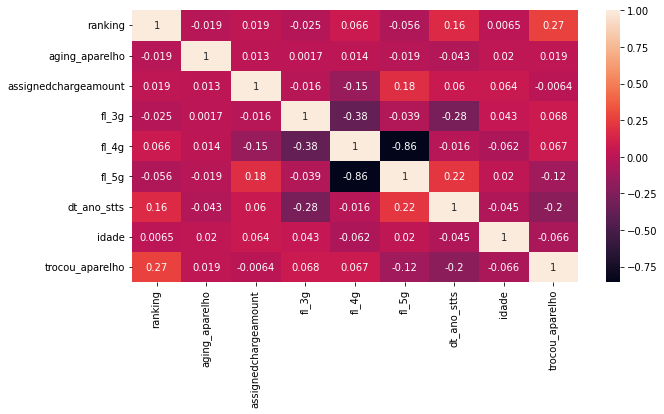

In [49]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

***
***
***
## Definição do Target trocou_aparelho

In [50]:
def plot_feature_freq(df, feature, qt_cat):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    order = np.argsort(counts)[::-1]
    labels, counts = labels[order], counts[order]

    g = sns.barplot(labels[:qt_cat], counts[:qt_cat])
    g.set_xticklabels(labels[:qt_cat], rotation=90)
    
    return g

In [51]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 33156, 1: 16599})

<AxesSubplot:>

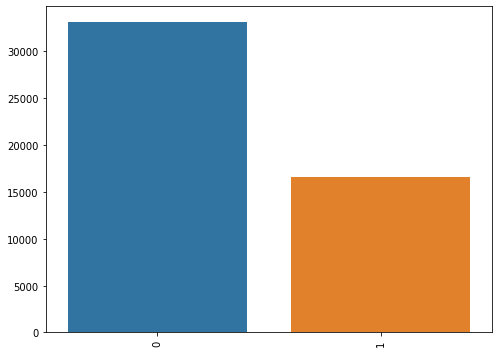

In [52]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho', len(dados_droped['trocou_aparelho'].unique()))

***
## Modelagem trocou_aparelho

In [53]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_ta[numerical_cols_ta] = scaler.fit_transform(X_ta[numerical_cols_ta])

In [54]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

In [55]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train_ta = X_train_ta.copy()
label_X_valid_ta = X_val_ta.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder_ta = OrdinalEncoder()
label_X_train_ta[object_cols_ta] = ordinal_encoder_ta.fit_transform(label_X_train_ta[object_cols_ta])
label_X_valid_ta[object_cols_ta] = ordinal_encoder_ta.fit_transform(label_X_valid_ta[object_cols_ta])

In [56]:
model_ta = GradientBoostingClassifier(random_state=2048)
model_ta.fit(label_X_train_ta, y_train_ta)
preds_ta = model_ta.predict(label_X_valid_ta)

***
### Feature Importance

In [57]:
import eli5
from eli5.sklearn import PermutationImportance

perm_ta = PermutationImportance(model_ta, n_iter=100).fit(label_X_valid_ta, y_val_ta)
eli5.show_weights(perm_ta, feature_names = label_X_valid_ta.columns.tolist())

Weight,Feature
0.0458 ± 0.0019,ranking
0.0218 ± 0.0024,dt_ano_stts
0.0064 ± 0.0028,idade
0.0025 ± 0.0005,fl_3g
0.0020 ± 0.0018,assignedchargeamount
0.0019 ± 0.0017,modelo
0.0015 ± 0.0016,fabricante
0.0011 ± 0.0012,aging_aparelho
0.0008 ± 0.0015,subscribermainofferdesc
0.0002 ± 0.0007,fl_5g


Permutation explainer: 24879it [37:25, 11.03it/s]                            


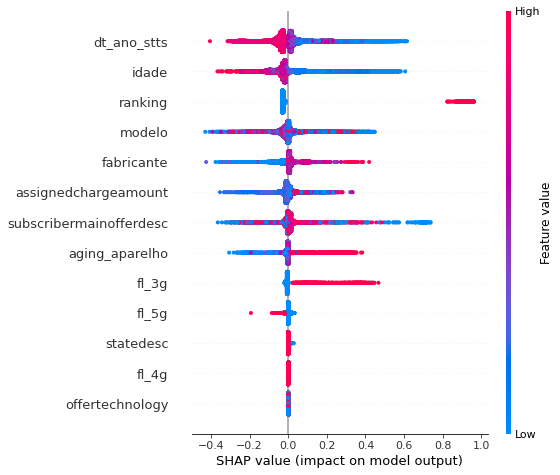

In [58]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer_ta = shap.Explainer(model_ta.predict, label_X_valid_ta)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values_ta = explainer_ta(label_X_valid_ta)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values_ta, label_X_valid_ta)

  0%|          | 0/2487 [00:00<?, ?it/s]

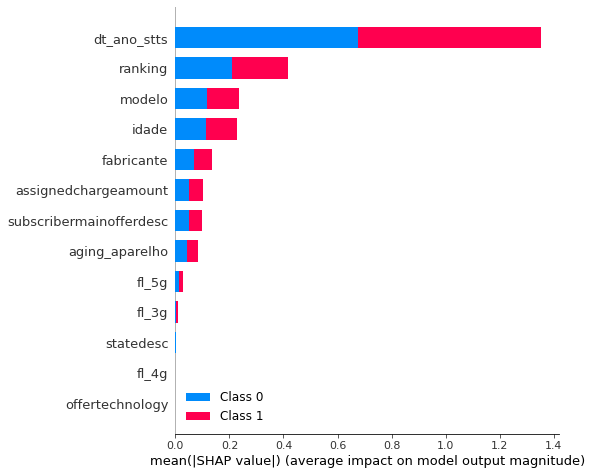

In [59]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample_ta = label_X_train_ta.sample(n=min(10, len(label_X_train_ta.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example_ta = label_X_valid_ta.sample(n=int((label_X_valid_ta.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict_ta = lambda x: model_ta.predict_proba(pd.DataFrame(x, columns=label_X_train_ta.columns))
explainer_ta2 = KernelExplainer(predict_ta, train_sample_ta, link="logit")
shap_values_ta2 = explainer_ta2.shap_values(example_ta, l1_reg=False)
summary_plot(shap_values_ta2, example_ta)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)

***
## Métricas

In [60]:
print(classification_report(y_val_ta, preds_ta))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81     16575
           1       0.71      0.22      0.34      8303

    accuracy                           0.71     24878
   macro avg       0.71      0.59      0.58     24878
weighted avg       0.71      0.71      0.65     24878



In [61]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,15820,755
1,6470,1833


Confusion matrix, without normalization
[[15820   755]
 [ 6470  1833]]
Normalized confusion matrix
[[0.95444947 0.04555053]
 [0.77923642 0.22076358]]


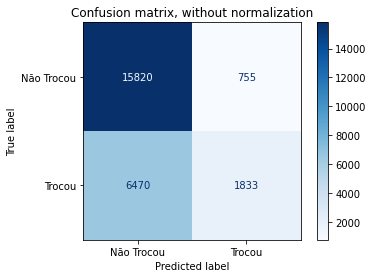

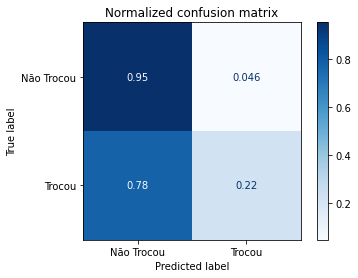

<Figure size 1296x1296 with 0 Axes>

In [63]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model_ta,
        label_X_valid_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

In [64]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

<AxesSubplot:>

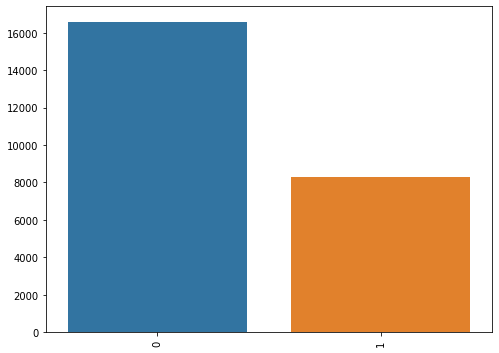

In [65]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho', len(X_val_ta['trocou_aparelho'].unique()))

In [66]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

<AxesSubplot:>

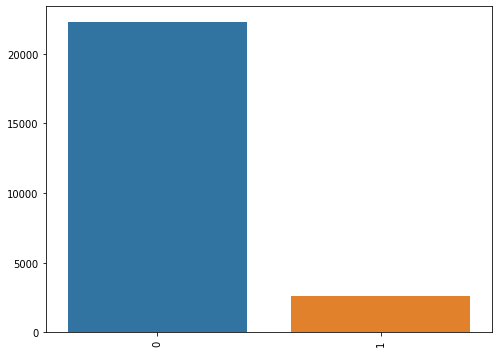

In [67]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto', len(X_val_ta['trocou_aparelho_previsto'].unique()))

In [68]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [69]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [70]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
X_val_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim
41297,Samsung Korea,GALAXY NOTE20 ULTRA 5G,-0.190648,1.623714,PostPaid,RIO DE JANEIRO,Titular Plano PÃ³s Vivo V 600GB,10.455654,-0.130249,-2.892800,3.379826,0.650775,1.970418,0,0,12899780778,2021-03-27,NaN
8829,XIAOMI,REDMI 9 (M2004J19AG),-0.190648,1.119512,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 60GB,-0.753863,-0.130249,0.345686,-0.295873,0.036413,-0.604996,1,0,271746033,2020-12-08,2022-06-04
17387,"Motorola Mobility LLC, a Lenovo Company",MOTO G PLAY (7TH GEN),-0.190648,0.615309,Controle,SAO PAULO,VIVO CONTROLE 11GB - ANUAL_,-0.045004,-0.130249,0.345686,-0.295873,0.036413,0.038857,1,0,16097048866,2021-01-06,2022-05-14
34985,APPLE,IPHONE XR (A1984),-0.190648,0.615309,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.413170,-0.130249,0.345686,-0.295873,-0.577948,-1.391928,0,0,42894096879,2021-06-16,NaN
49557,Samsung Korea,GALAXY A01 CORE,-0.190648,-1.401502,Controle,MINAS GERAIS,VIVO CONTROLE 8GB II,-0.114317,-0.130249,0.345686,-0.295873,0.650775,0.181936,0,0,81251700578,2021-10-05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5590,Samsung Korea,GALAXY A10S,-0.190648,-0.897300,Controle,SAO PAULO,VIVO CONTROLE 4GB II,-0.386955,-0.130249,0.345686,-0.295873,0.650775,-0.247300,1,0,27458278803,2021-03-20,2022-05-02
48623,ASUS,ZENFONE MAX M1,-0.190648,-1.401502,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.413170,-0.130249,0.345686,-0.295873,-0.577948,0.539632,0,0,25067275820,2021-09-28,NaN
36367,SAMSUNG,GALAXY A7 2018 (SM-A750F DS),-0.190648,-0.897300,Controle,SAO PAULO,VIVO CTRL DIGITAL-11GB ILIM_,-0.045004,-0.130249,0.345686,-0.295873,-0.577948,0.396554,1,0,13917177838,2021-03-20,2022-05-05
4037,"Motorola Mobility LLC, a Lenovo Company",CEBU20,-0.190648,0.111106,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,0.923805,-0.130249,0.345686,-0.295873,0.650775,0.825789,0,0,7579081873,2021-07-08,NaN


In [71]:
X_val_ta['aging_aparelho_ori'] = dados_droped['aging_aparelho']
X_val_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,aging_aparelho_ori
41297,Samsung Korea,GALAXY NOTE20 ULTRA 5G,-0.190648,1.623714,PostPaid,RIO DE JANEIRO,Titular Plano PÃ³s Vivo V 600GB,10.455654,-0.130249,-2.892800,3.379826,0.650775,1.970418,0,0,12899780778,2021-03-27,NaN,18
8829,XIAOMI,REDMI 9 (M2004J19AG),-0.190648,1.119512,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 60GB,-0.753863,-0.130249,0.345686,-0.295873,0.036413,-0.604996,1,0,271746033,2020-12-08,2022-06-04,17
17387,"Motorola Mobility LLC, a Lenovo Company",MOTO G PLAY (7TH GEN),-0.190648,0.615309,Controle,SAO PAULO,VIVO CONTROLE 11GB - ANUAL_,-0.045004,-0.130249,0.345686,-0.295873,0.036413,0.038857,1,0,16097048866,2021-01-06,2022-05-14,16
34985,APPLE,IPHONE XR (A1984),-0.190648,0.615309,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.413170,-0.130249,0.345686,-0.295873,-0.577948,-1.391928,0,0,42894096879,2021-06-16,NaN,16
49557,Samsung Korea,GALAXY A01 CORE,-0.190648,-1.401502,Controle,MINAS GERAIS,VIVO CONTROLE 8GB II,-0.114317,-0.130249,0.345686,-0.295873,0.650775,0.181936,0,0,81251700578,2021-10-05,NaN,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5590,Samsung Korea,GALAXY A10S,-0.190648,-0.897300,Controle,SAO PAULO,VIVO CONTROLE 4GB II,-0.386955,-0.130249,0.345686,-0.295873,0.650775,-0.247300,1,0,27458278803,2021-03-20,2022-05-02,13
48623,ASUS,ZENFONE MAX M1,-0.190648,-1.401502,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.413170,-0.130249,0.345686,-0.295873,-0.577948,0.539632,0,0,25067275820,2021-09-28,NaN,12
36367,SAMSUNG,GALAXY A7 2018 (SM-A750F DS),-0.190648,-0.897300,Controle,SAO PAULO,VIVO CTRL DIGITAL-11GB ILIM_,-0.045004,-0.130249,0.345686,-0.295873,-0.577948,0.396554,1,0,13917177838,2021-03-20,2022-05-05,13
4037,"Motorola Mobility LLC, a Lenovo Company",CEBU20,-0.190648,0.111106,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,0.923805,-0.130249,0.345686,-0.295873,0.650775,0.825789,0,0,7579081873,2021-07-08,NaN,15


***
***
***
## Separando as bases para outro modelo

In [72]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,aging_aparelho_ori
0,SAMSUNG,GALAXY J5 DUOS (SM-J500M DS),-0.190648,1.623714,Controle,SAO PAULO,VIVO CONTROLE 8GB II,-0.166747,-0.130249,0.345686,-0.295873,-1.192310,-1.892703,1,1,50438392876,2020-09-07,2022-04-02,18
1,Samsung Korea,GALAXY S20 FE,5.245273,1.119512,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 20GB+220GB BONUS,2.391857,-0.130249,0.345686,-0.295873,0.650775,2.757350,1,1,235512834,2021-05-13,NaN,17
2,Xiaomi Communications Co Ltd,REDMI 6A,-0.190648,1.623714,Controle,SERGIPE,VIVO CONTROLE 6GB III,-0.271608,-0.130249,0.345686,-0.295873,-0.577948,-0.962692,0,1,36116053874,2021-03-28,NaN,18
3,SAMSUNG,"GALAXY A70 (SM-A705FN,DS)",-0.190648,1.623714,Controle,SAO PAULO,VIVO CONTROLE 7GB_ANUAL_,-0.194430,-0.130249,0.345686,-0.295873,0.036413,-1.678085,0,1,46268356861,2021-03-21,NaN,18
4,MOTOROLA,MOTO G4 PLAY,-0.190648,-0.897300,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.413170,-0.130249,0.345686,-0.295873,-1.192310,-1.821164,1,1,48711238801,2021-04-26,2022-06-20,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,Samsung Korea,GALAXY S20 FE,5.245273,0.111106,Controle,SAO PAULO,VIVO CONTROLE 8GB,0.147940,-0.130249,0.345686,-0.295873,0.650775,0.110397,1,1,16876054837,2021-06-27,NaN,15
2584,SAMSUNG,"GALAXY A20S (SM-A207M,DS)",-0.190648,0.111106,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,-0.753863,-0.130249,0.345686,-0.295873,0.036413,-1.678085,0,1,49378586880,2021-07-05,NaN,15
2585,Samsung Korea,GALAXY A20,-0.190648,-1.401502,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 180GB,-0.753863,-0.130249,0.345686,-0.295873,0.036413,-0.175760,0,1,19229289841,2021-09-23,NaN,12
2586,SAMSUNG,"GALAXY J4 PLUS (SM-J415G,DS)",-0.190648,0.615309,Controle,SAO PAULO,VIVO CONTROLE 8GB II,-0.166747,-0.130249,0.345686,-0.295873,-0.577948,-1.606546,0,1,47834545825,2021-05-31,NaN,16


***
***
***
## Definição do Target aging_aparelho

In [73]:
# define target
y = base_to_pred_month['aging_aparelho_ori']

In [74]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({18: 497, 17: 368, 13: 398, 12: 404, 15: 277, 14: 309, 16: 335})

<AxesSubplot:>

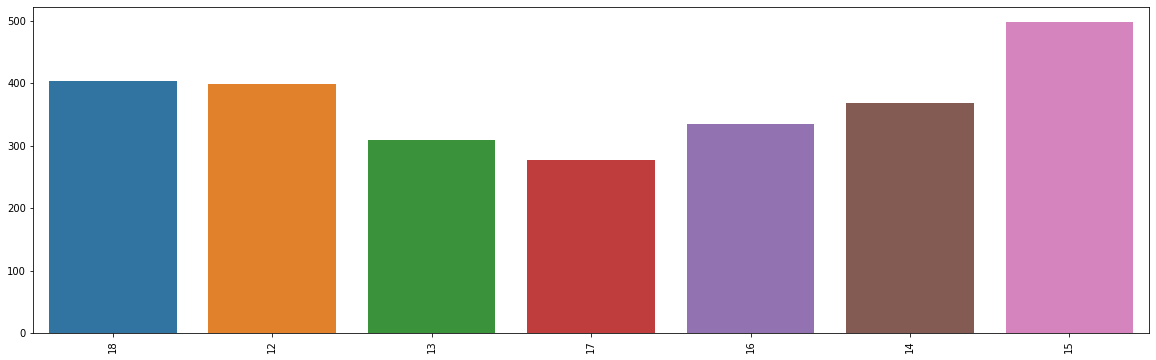

In [75]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho_ori', len(base_to_pred_month['aging_aparelho_ori'].unique()))

### Definicão das features

In [76]:
# define features
X = base_to_pred_month[['fabricante', 'modelo',
                        'ranking',
                        'offertechnology', 
                        'statedesc', 'subscribermainofferdesc',
                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                        'dt_ano_stts', 'idade']]
X

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,SAMSUNG,GALAXY J5 DUOS (SM-J500M DS),-0.190648,Controle,SAO PAULO,VIVO CONTROLE 8GB II,-0.166747,-0.130249,0.345686,-0.295873,-1.192310,-1.892703
1,Samsung Korea,GALAXY S20 FE,5.245273,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 20GB+220GB BONUS,2.391857,-0.130249,0.345686,-0.295873,0.650775,2.757350
2,Xiaomi Communications Co Ltd,REDMI 6A,-0.190648,Controle,SERGIPE,VIVO CONTROLE 6GB III,-0.271608,-0.130249,0.345686,-0.295873,-0.577948,-0.962692
3,SAMSUNG,"GALAXY A70 (SM-A705FN,DS)",-0.190648,Controle,SAO PAULO,VIVO CONTROLE 7GB_ANUAL_,-0.194430,-0.130249,0.345686,-0.295873,0.036413,-1.678085
4,MOTOROLA,MOTO G4 PLAY,-0.190648,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.413170,-0.130249,0.345686,-0.295873,-1.192310,-1.821164
...,...,...,...,...,...,...,...,...,...,...,...,...
2583,Samsung Korea,GALAXY S20 FE,5.245273,Controle,SAO PAULO,VIVO CONTROLE 8GB,0.147940,-0.130249,0.345686,-0.295873,0.650775,0.110397
2584,SAMSUNG,"GALAXY A20S (SM-A207M,DS)",-0.190648,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,-0.753863,-0.130249,0.345686,-0.295873,0.036413,-1.678085
2585,Samsung Korea,GALAXY A20,-0.190648,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 180GB,-0.753863,-0.130249,0.345686,-0.295873,0.036413,-0.175760
2586,SAMSUNG,"GALAXY J4 PLUS (SM-J415G,DS)",-0.190648,Controle,SAO PAULO,VIVO CONTROLE 8GB II,-0.166747,-0.130249,0.345686,-0.295873,-0.577948,-1.606546


#### Variaveis Categoricas

In [77]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [78]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  7
['ranking', 'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']


***
## Mostrando a correlação entre os dados numéricos

In [79]:
corr_mes_previsao = base_to_pred_month[['fabricante', 'modelo',
                                        'ranking',
                                        'offertechnology', 
                                        'statedesc', 'subscribermainofferdesc',
                                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                        'dt_ano_stts', 'idade', 'aging_aparelho_ori']]

<AxesSubplot:>

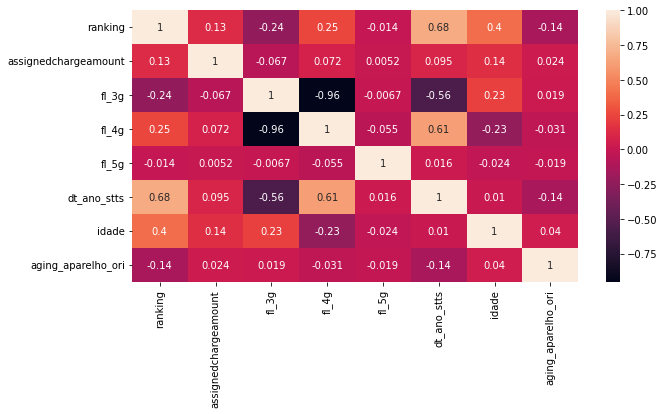

In [80]:
corr2 = corr_mes_previsao.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr2, xticklabels = corr2.columns, yticklabels = corr2.columns, annot = True)

***
## Modelagem

In [81]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [82]:
# Dividindo as features em dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

In [83]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_val.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.fit_transform(label_X_valid[object_cols])

model = GradientBoostingClassifier(random_state=2048)
model.fit(label_X_train, y_train)
preds = model.predict(label_X_valid)

***
### Feature Importance

In [84]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, n_iter=100).fit(label_X_valid, y_val)
eli5.show_weights(perm, feature_names = label_X_valid.columns.tolist())


Weight,Feature
0.0607 ± 0.0116,dt_ano_stts
0.0211 ± 0.0142,idade
0.0203 ± 0.0111,fabricante
0.0168 ± 0.0130,modelo
0.0109 ± 0.0114,subscribermainofferdesc
0.0093 ± 0.0124,assignedchargeamount
0.0019 ± 0.0052,fl_3g
0.0014 ± 0.0026,fl_4g
0.0009 ± 0.0025,ranking
0 ± 0.0000,fl_5g


Permutation explainer: 1295it [06:39,  3.16it/s]                          


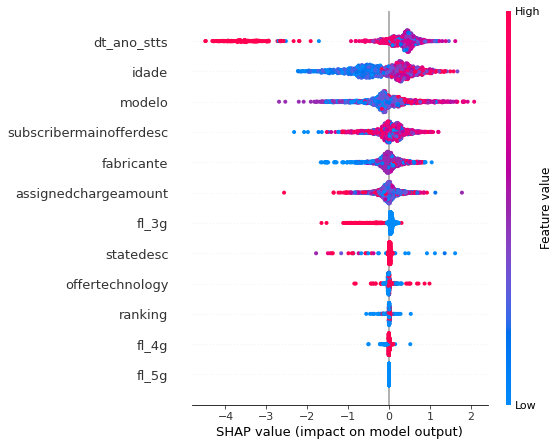

In [85]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.Explainer(model.predict, label_X_valid)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer(label_X_valid)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, label_X_valid)

  0%|          | 0/129 [00:00<?, ?it/s]

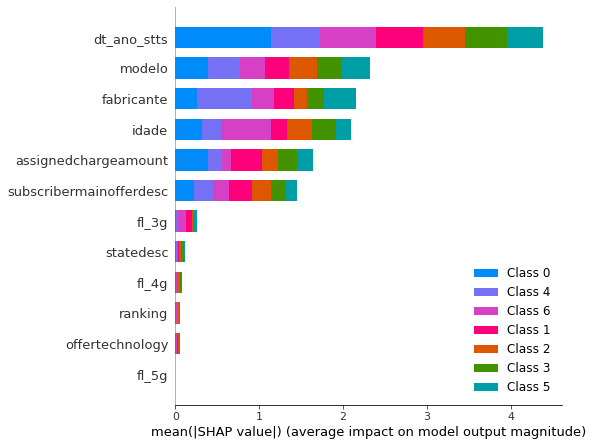

In [92]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = label_X_train.sample(n=min(10, len(label_X_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = label_X_valid.sample(n=int((label_X_valid.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=label_X_train.columns))
explainer2 = KernelExplainer(predict, train_sample, link="logit")
shap_values2 = explainer2.shap_values(example, l1_reg=False)
summary_plot(shap_values2, example)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)

***
## Métricas

In [87]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

          12       0.44      0.34      0.38       185
          13       0.29      0.14      0.19       214
          14       0.19      0.09      0.12       168
          15       0.11      0.07      0.09       138
          16       0.15      0.54      0.24       155
          17       0.10      0.04      0.06       193
          18       0.36      0.38      0.37       241

    accuracy                           0.23      1294
   macro avg       0.23      0.23      0.21      1294
weighted avg       0.25      0.23      0.22      1294



In [88]:
cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
                     index = sorted(Counter(y_val)),
                     columns = sorted(Counter(preds)))
cm_df

,12,13,14,15,16,17,18
12,62,30,8,9,56,8,12
13,45,31,10,14,75,13,26
14,14,8,15,13,70,16,32
15,10,12,14,10,62,6,24
16,2,10,10,13,83,10,27
17,7,4,12,19,101,8,42
18,1,12,12,11,97,17,91


## Plot non-normalized confusion matrix

Confusion matrix, without normalization
[[ 62  30   8   9  56   8  12]
 [ 45  31  10  14  75  13  26]
 [ 14   8  15  13  70  16  32]
 [ 10  12  14  10  62   6  24]
 [  2  10  10  13  83  10  27]
 [  7   4  12  19 101   8  42]
 [  1  12  12  11  97  17  91]]
Normalized confusion matrix
[[0.33513514 0.16216216 0.04324324 0.04864865 0.3027027  0.04324324
  0.06486486]
 [0.21028037 0.14485981 0.04672897 0.06542056 0.35046729 0.06074766
  0.12149533]
 [0.08333333 0.04761905 0.08928571 0.07738095 0.41666667 0.0952381
  0.19047619]
 [0.07246377 0.08695652 0.10144928 0.07246377 0.44927536 0.04347826
  0.17391304]
 [0.01290323 0.06451613 0.06451613 0.08387097 0.53548387 0.06451613
  0.17419355]
 [0.03626943 0.02072539 0.06217617 0.0984456  0.52331606 0.04145078
  0.21761658]
 [0.00414938 0.04979253 0.04979253 0.04564315 0.40248963 0.07053942
  0.37759336]]


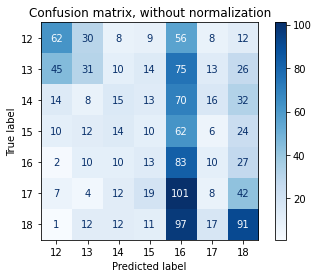

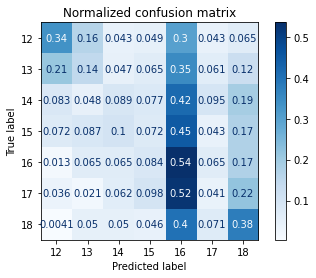

<Figure size 1296x1296 with 0 Axes>

In [94]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        label_X_valid,
        y_val,
        display_labels=['12', '13', '14', '15', '16', '17', '18'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [95]:
X_val['aging_aparelho'] = y_val
# X_val

In [96]:
X_val['previsto'] = preds
# X_val

In [97]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [98]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [99]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [100]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,aging_aparelho,previsto,cpfidentifier,dt_inicio,dt_fim,dt_fim_previsto
2491,"Motorola Mobility LLC, a Lenovo Company","BL12427345, MOTO G (6TH GEN)",-0.698721,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,-0.463033,-0.340585,0.35662,-0.019661,-0.602811,-0.591823,14,15,40415828813,2021-02-15,2022-04-16,2022-05
10,SAMSUNG,GALAXY S20 FE (SM-G780F),1.431186,Controle,SAO PAULO,VIVO CONTROLE 5GB IV,-0.400552,-0.340585,0.35662,-0.019661,0.821482,0.788964,18,16,13043203836,2021-03-24,NaN,2022-07
2497,SAMSUNG,GALAXY S20 FE (SM-G780F),1.431186,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,-0.914143,-0.340585,0.35662,-0.019661,0.821482,0.167610,16,16,27277102835,2021-05-26,NaN,2022-09
2202,"Motorola Mobility LLC, a Lenovo Company",ARUBA21,1.431186,Controle,SAO PAULO,VIVO CONTROLE 11GB - ANUAL_,0.024455,-0.340585,0.35662,-0.019661,1.296246,-0.177587,12,12,42909472809,2021-10-09,NaN,2022-10
1296,MOTOROLA,MOTO G PLUS (5TH GEN S) (XT1802),-0.698721,Controle,SAO PAULO,VIVO CONTROLE 6GB III,-0.206168,-0.340585,0.35662,-0.019661,-0.602811,-0.867981,17,18,40113656882,2021-05-05,NaN,2022-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),-0.698721,Controle,SAO PAULO,VIVO CONTROLE 7GB_,-0.173400,-0.340585,0.35662,-0.019661,-1.077576,-0.729902,15,16,6312482502,2021-07-20,NaN,2022-11
1215,SAMSUNG,GALAXY S20 FE (SM-G780F),1.431186,Controle,SAO PAULO,VIVO CONTROLE 8GB II PLN,-0.203113,-0.340585,0.35662,-0.019661,0.821482,-0.315666,17,16,36981871831,2021-05-11,NaN,2022-09
1174,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",-0.698721,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 300GB,-0.914143,-0.340585,0.35662,-0.019661,0.346717,-0.246626,18,16,31655746855,2021-04-06,NaN,2022-08
783,"Motorola Mobility LLC, a Lenovo Company",TROIKA,-0.698721,Controle,SAO PAULO,VIVO CONTROLE 6GB III,-0.206168,-0.340585,0.35662,-0.019661,0.346717,-0.660863,15,16,42562616804,2021-07-14,NaN,2022-11


<AxesSubplot:>

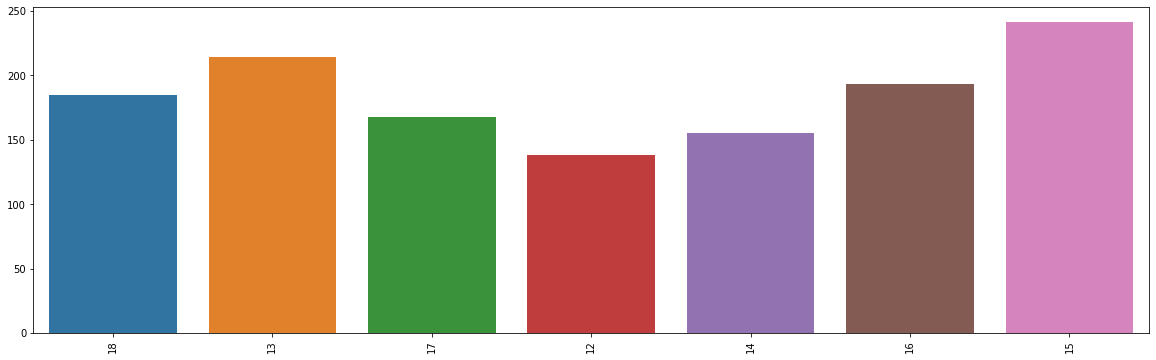

In [103]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'aging_aparelho', len(X_val['aging_aparelho'].unique()))

<AxesSubplot:>

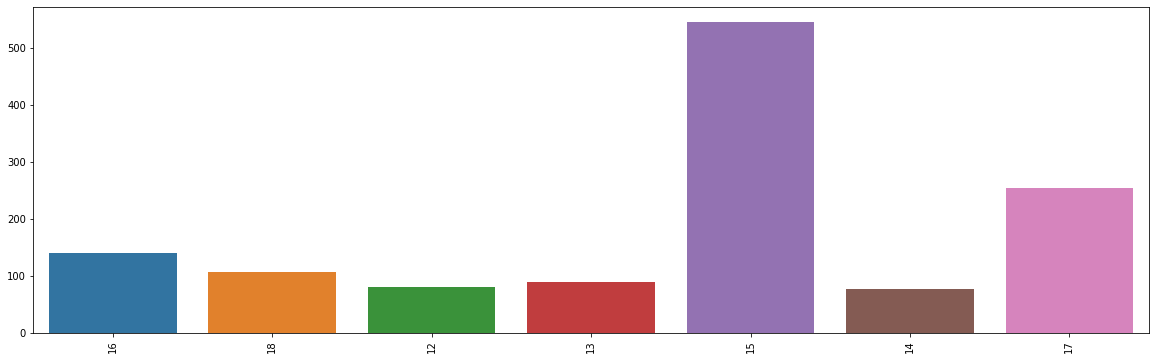

In [104]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'previsto', len(X_val['previsto'].unique()))